In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [5]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# SETUP

In [6]:
CONFIG_DIR = '../app/'

In [7]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [8]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-20'
TETS_DATE = '2022-10-09'

In [9]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 1500],
            'buy_count_24H': [0, 3000],
            'sell_count_24H': [0, 5000],
            'cancel_count_24H': [0, 1000],
            #'token_all_activity_3H': [0, 30],
            #'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1665554362,65681,65004,sell,0x17d288f53083015bcdca3ecdf9396a577a0005de,NaN,0.25,sneakers,common,coacher,...,0.24,0.24,0.24,59.0,59.0,438.0,683.0,789.0,109.0,898.0
1,1665554335,65680,54192,sell,0x7362b48e909e374354eeb34a825891ae1f0c73fe,NaN,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,198.0,300.0,437.0,682.0,788.0,109.0,897.0
2,1665554305,64167,35970,cancel,0xa5b05b1811aa217f0340fb342cdee2f35f1c1c91,NaN,NaN,sneakers,uncommon,ranger,...,1.00,1.00,0.24,9.0,28.0,83.0,100.0,789.0,109.0,898.0
3,1665554296,65679,28538,sell,0x33715efdc5a45d126d8b03fe04347efdd63265ba,NaN,0.25,sneakers,common,coacher,...,0.25,0.24,0.24,84.0,107.0,244.0,681.0,788.0,109.0,897.0
4,1665554269,65496,64973,cancel,0x30bf6e17dc66a2c2a09a13c64c9a7800823a529a,NaN,NaN,sneakers,uncommon,sprinter,...,1.00,1.00,0.24,27.0,27.0,85.0,102.0,790.0,109.0,899.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103298,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103299,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103300,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103301,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data.columns[:-10]

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [13]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103303 entries, 0 to 103302
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  48857 non-null  float64
 1   time_ownership             48857 non-null  float64
 2   wallet_box_mint            48857 non-null  float64
 3   wallet_sneaker_mint        48857 non-null  float64
 4   time_level_up              66566 non-null  float64
 5   time_level_up_for_mint     71032 non-null  float64
 6   base_mint_price_amt        71032 non-null  float64
 7   base_mint_price_azy        71032 non-null  float64
 8   base_mint_price_bnb        61009 non-null  float64
dtypes: float64(9)
memory usage: 7.1 MB


In [14]:
data.genesis

0         False
1         False
2         False
3          True
4         False
          ...  
103298     True
103299    False
103300    False
103301    False
103302     True
Name: genesis, Length: 103303, dtype: bool

In [15]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
31,1665553933,65554,24965,buy,0x9fbff748a2ca2da037a86e5c86770312dfdaa6bd,0xca8cd3a68db5290e09c1db44e21b8f7d6ba8b9da,0.24,sneakers,common,ranger,...,0.25,0.24,0.24,4.0,108.0,246.0,690.0,800.0,109.0,909.0
48,1665553819,65518,50014,buy,0x2a336a7c088bc330aed36b06123fb81951b15f62,0x6022b378180c7c8edbefd19d21dce026b9fd008d,0.25,sneakers,common,ranger,...,0.24,0.24,0.24,86.0,310.0,448.0,695.0,809.0,109.0,918.0
58,1665553630,65610,24781,buy,0x8fa6f613865d58adac085d0566f586bd849fee80,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,82.0,107.0,247.0,698.0,812.0,109.0,921.0
70,1665553555,64521,20041,buy,0x74ec3019005ba1c7c9044d720f700cd288ef6774,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,84.0,109.0,249.0,698.0,815.0,109.0,924.0
86,1665553423,65516,57977,buy,0x348a88be331bcbf7562461913f5851ccae418d85,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.28,sneakers,common,coacher,...,0.24,0.24,0.24,86.0,312.0,453.0,702.0,819.0,109.0,928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103240,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103263,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103277,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103282,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [16]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

cancel_count_24H more then expected. get: 2777 | expected: 1000


In [17]:
data['mint'].isna().sum()

0

In [18]:
data[data['level'] == 9]['mint'].value_counts()

2.0    361
3.0     95
0.0     94
1.0     50
4.0      3
Name: mint, dtype: int64

In [19]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
466,1665548572,63878,15411,buy,0xee66527abd321220c483c4f38aa5180638df112e,0x413499bc0260eebfb6f26bdd0572c20575c96ee5,1.90,sneakers,common,coacher,...,0.24,0.22,0.22,19.0,34.0,251.0,736.0,863.0,109.0,972.0
831,1665543039,63672,39417,buy,0xcc37e28a6328813b2b0032342663972de669bed5,0xcbd9dbccaf4ea7526ba056e144d7500e54608347,0.54,sneakers,common,coacher,...,0.22,0.22,0.22,6.0,19.0,472.0,732.0,856.0,111.0,967.0
954,1665541797,64069,35494,buy,0x6022b378180c7c8edbefd19d21dce026b9fd008d,0x7a79ddd38846702ee1673eeb69e20a82358af8ba,0.40,sneakers,common,ranger,...,0.22,0.22,0.22,5.0,18.0,476.0,735.0,858.0,111.0,969.0
1859,1665529334,64764,39192,buy,0xc937de0f393752b7c1108947ac45b34bed5b1956,0x8054bf1f1a6fbecb52f90eacaab28cfe57c4ee5c,2.37,sneakers,uncommon,coacher,...,1.00,1.00,0.23,10.0,15.0,102.0,123.0,823.0,115.0,938.0
1975,1665527052,64593,29092,buy,0x9ebbf453e088de4b9cc206fece5e9858c41c814f,0x63b5bce96355bbbdd384f090bf8b0f651b4ba47d,1.59,sneakers,uncommon,hiker,...,1.56,1.00,0.23,1.0,11.0,23.0,127.0,837.0,110.0,947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98675,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99451,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100604,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100965,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17782 entries, 31 to 103296
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        17782 non-null  int64  
 1   mrk_id                                           17782 non-null  int64  
 2   token_id                                         17782 non-null  int64  
 3   event                                            17782 non-null  object 
 4   wallet_from                                      17677 non-null  object 
 5   wallet_to                                        17782 non-null  object 
 6   price                                            17782 non-null  float64
 7   item_type                                        17782 non-null  object 
 8   rarity                                           17782 non-null  object 
 9   sneaker_type              

In [21]:
data[['diff_prev_price', 'count_waller_buyer', 'count_holder',
       'count_sneaker', 'count_sneaker_type', 'count_new_sneaker_1d',
       'count_new_sneaker_7d', 'count_new_sneaker_14d',
       'count_new_sneaker_30d', 'ratio_sneaker_genesis',
       'mkr_floor__rarity_type_genesis_lvl_mint',
       'mrk_floor__rarity_type_genesis_lvl']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17782 entries, 31 to 103296
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   diff_prev_price                          10804 non-null  float64
 1   count_waller_buyer                       10129 non-null  float64
 2   count_holder                             10129 non-null  float64
 3   count_sneaker                            17782 non-null  object 
 4   count_sneaker_type                       17782 non-null  object 
 5   count_new_sneaker_1d                     17782 non-null  object 
 6   count_new_sneaker_7d                     17782 non-null  object 
 7   count_new_sneaker_14d                    17782 non-null  object 
 8   count_new_sneaker_30d                    17782 non-null  object 
 9   ratio_sneaker_genesis                    10129 non-null  float64
 10  mkr_floor__rarity_type_genesis_lvl_mint  100

In [22]:
data[['diff_prev_price', 'count_waller_buyer', 'count_holder',
       'count_sneaker', 'count_sneaker_type', 'count_new_sneaker_1d',
       'count_new_sneaker_7d', 'count_new_sneaker_14d',
       'count_new_sneaker_30d', 'ratio_sneaker_genesis',
       'mkr_floor__rarity_type_genesis_lvl_mint',
       'mrk_floor__rarity_type_genesis_lvl']]

,diff_prev_price,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,ratio_sneaker_genesis,mkr_floor__rarity_type_genesis_lvl_mint,mrk_floor__rarity_type_genesis_lvl
31,-1.48,682.0,9771.0,33962.0,9724.0,87.0,1296.0,3676.0,10764.0,1.840625,0.25,0.25
48,NaN,685.0,9770.0,33962.0,9724.0,87.0,1296.0,3676.0,10764.0,0.537688,0.25,0.24
58,0.00,687.0,9770.0,33962.0,4788.0,87.0,1297.0,3676.0,10765.0,1.869159,0.25,0.24
70,NaN,688.0,9769.0,33962.0,4788.0,87.0,1297.0,3676.0,10765.0,1.860681,0.25,0.24
86,0.00,688.0,9769.0,33962.0,4788.0,87.0,1297.0,3676.0,10765.0,0.533884,0.25,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...
103240,-0.03,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN,NaN
103263,-0.12,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN,NaN
103277,NaN,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN,NaN
103282,0.08,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN,NaN


In [23]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [24]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [25]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [26]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17782 entries, 31 to 103296
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        17782 non-null  int64  
 1   mrk_id                                           17782 non-null  int64  
 2   token_id                                         17782 non-null  int64  
 3   event                                            17782 non-null  object 
 4   wallet_from                                      17677 non-null  object 
 5   wallet_to                                        17782 non-null  object 
 6   price                                            17782 non-null  float64
 7   item_type                                        17782 non-null  object 
 8   rarity                                           17782 non-null  object 
 9   sneaker_type              

In [28]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
31,1665553933,65554,24965,buy,0x9fbff748a2ca2da037a86e5c86770312dfdaa6bd,0xca8cd3a68db5290e09c1db44e21b8f7d6ba8b9da,0.24,sneakers,common,ranger,...,0.25,0.24,0.24,4.0,108.0,246.0,690.0,800.0,109.0,909.0
48,1665553819,65518,50014,buy,0x2a336a7c088bc330aed36b06123fb81951b15f62,0x6022b378180c7c8edbefd19d21dce026b9fd008d,0.25,sneakers,common,ranger,...,0.24,0.24,0.24,86.0,310.0,448.0,695.0,809.0,109.0,918.0
58,1665553630,65610,24781,buy,0x8fa6f613865d58adac085d0566f586bd849fee80,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,82.0,107.0,247.0,698.0,812.0,109.0,921.0
70,1665553555,64521,20041,buy,0x74ec3019005ba1c7c9044d720f700cd288ef6774,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,84.0,109.0,249.0,698.0,815.0,109.0,924.0
86,1665553423,65516,57977,buy,0x348a88be331bcbf7562461913f5851ccae418d85,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.28,sneakers,common,coacher,...,0.24,0.24,0.24,86.0,312.0,453.0,702.0,819.0,109.0,928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103240,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103263,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103277,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103282,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [30]:
len(data)

17782

In [31]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

17573

уберем выбросы

In [32]:
data = data[(data['price'] > 0.1)]
len(data)

17573

In [33]:
data = data[~((data['genesis']) & (data['price'] < 0.1))].copy()
len(data)

17573

In [34]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

6428

In [35]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [36]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [37]:
#data['bin_level'].value_counts()

In [38]:
#data['bin_mint'].value_counts()

In [39]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [40]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [41]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [42]:
data['token_sell_activity_6H'].max()

12.0

In [43]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [44]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [45]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

6428

In [46]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [47]:
data[['diff_prev_price', 'count_waller_buyer', 'count_holder',
       'count_sneaker', 'count_sneaker_type', 'count_new_sneaker_1d',
       'count_new_sneaker_7d', 'count_new_sneaker_14d',
       'count_new_sneaker_30d', 'ratio_sneaker_genesis',
       'mkr_floor__rarity_type_genesis_lvl_mint',
       'mrk_floor__rarity_type_genesis_lvl']]

,diff_prev_price,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,ratio_sneaker_genesis,mkr_floor__rarity_type_genesis_lvl_mint,mrk_floor__rarity_type_genesis_lvl
63884,-0.06,379.0,8157.0,26291,7919,453,2760,5590,10299,1.014019,0.90,0.90
63862,0.05,390.0,8155.0,26301,6772,456,2766,5594,10275,0.910638,0.85,0.85
63855,NaN,389.0,8157.0,26303,7268,454,2766,5594,10267,0.918455,0.89,0.89
63853,NaN,388.0,8157.0,26303,6772,454,2766,5594,10265,0.914530,0.85,0.85
63852,-0.03,387.0,8158.0,26303,6772,454,2766,5594,10263,1.088785,0.90,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.00,688.0,9769.0,33962.0,4788.0,87.0,1297.0,3676.0,10765.0,0.533884,0.25,0.24
70,NaN,688.0,9769.0,33962.0,4788.0,87.0,1297.0,3676.0,10765.0,1.860681,0.25,0.24
58,0.00,687.0,9770.0,33962.0,4788.0,87.0,1297.0,3676.0,10765.0,1.869159,0.25,0.24
48,NaN,685.0,9770.0,33962.0,9724.0,87.0,1296.0,3676.0,10764.0,0.537688,0.25,0.24


In [48]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
63884,272.876094,0.077964,0.549084,0.660806
63862,270.648020,0.075938,0.551437,0.667356
63855,270.168787,0.076940,0.551756,0.669636
63853,270.168787,0.076940,0.551756,0.669636
63852,269.922363,0.076734,0.551790,0.670132
...,...,...,...,...
20059,276.742247,0.062105,0.274524,0.342478
20055,276.742247,0.062105,0.274524,0.342478
20030,276.730740,0.062159,0.273278,0.341181
20020,276.730740,0.062159,0.273278,0.341181


In [49]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [50]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
63884,272.876094,0.077964,0.549084,1.657810e+09,24145.0,5.0,3.0,900.0,1800.0,300.0,200.0,0.660806,2022-09-20 00:00:15
63862,270.648020,0.075938,0.551437,1.659899e+09,379741.0,3.0,2.0,900.0,1800.0,300.0,200.0,0.667356,2022-09-20 01:08:29
63855,270.168787,0.076940,0.551756,1.659095e+09,11019.0,3.0,4.0,0.0,1800.0,300.0,200.0,0.669636,2022-09-20 01:27:45
63853,270.168787,0.076940,0.551756,1.658100e+09,714994.0,9.0,12.0,900.0,1800.0,300.0,200.0,0.669636,2022-09-20 01:31:35
63852,269.922363,0.076734,0.551790,1.657821e+09,29634.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.670132,2022-09-20 01:34:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20059,276.742247,0.062105,0.274524,1.657801e+09,613296.0,17.0,3.0,900.0,1800.0,300.0,200.0,0.342478,2022-10-08 23:38:40
20055,276.742247,0.062105,0.274524,1.657801e+09,552668.0,18.0,18.0,900.0,1800.0,300.0,200.0,0.342478,2022-10-08 23:42:28
20030,276.730740,0.062159,0.273278,1.657880e+09,799050.0,8.0,8.0,900.0,1800.0,300.0,200.0,0.341181,2022-10-08 23:55:13
20020,276.730740,0.062159,0.273278,1.657811e+09,4628133.0,3.0,3.0,900.0,1800.0,300.0,200.0,0.341181,2022-10-08 23:57:46


In [51]:
train_data.base_mint_price_azy.value_counts()

200.0     6040
800.0      383
3200.0       5
Name: base_mint_price_azy, dtype: int64

In [52]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    #'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'diff_prev_price', 
    #'count_waller_buyer', 
    #'count_holder',
    #'count_sneaker', 
    #'count_sneaker_type', 
    #'count_new_sneaker_1d',
    #'count_new_sneaker_7d', 
    #'count_new_sneaker_14d',
    #'count_new_sneaker_30d', 
    'ratio_sneaker_genesis',
    'mkr_floor__rarity_type_genesis_lvl_mint',
    'mrk_floor__rarity_type_genesis_lvl',
    ]

cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [53]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [54]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.21s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.22s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:06,  2.24s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:08,  2.22s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:11,  2.20s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:13,  2.19s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:15,  2.18s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:17,  2.17s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:19,  2.18s/it]iteritems is deprec

In [55]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.903,0.0815
MAE,0.063,0.0116
MSE,0.073,0.0975
RMSE,0.230,0.1434
MAPE,0.060,0.0075


In [56]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.903,0.0815
MAE,0.063,0.0116
MSE,0.073,0.0975
RMSE,0.230,0.1434
MAPE,0.060,0.0075


In [57]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.883, 'MAE': 0.063, 'MSE': 0.073, 'RMSE': 0.27, 'MAPE': 0.06}

In [58]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


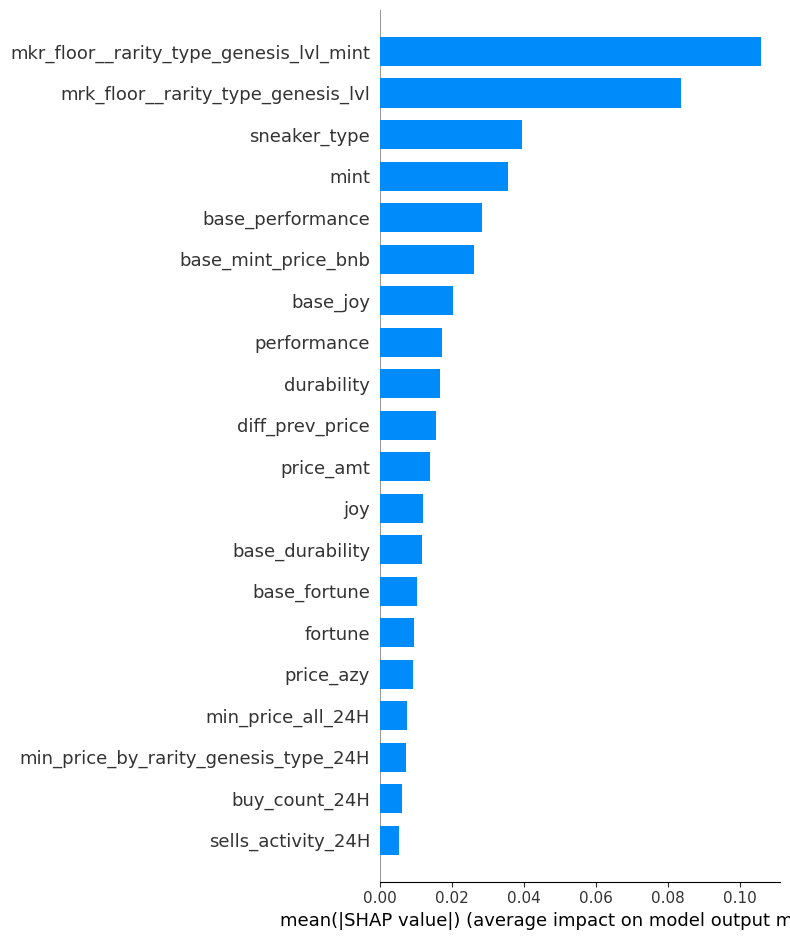

In [59]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [60]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.054936
0:	learn: 0.7589296	total: 3.54ms	remaining: 3.53s
1:	learn: 0.7295931	total: 6.83ms	remaining: 3.41s
2:	learn: 0.7020112	total: 9.29ms	remaining: 3.09s
3:	learn: 0.6780680	total: 11.7ms	remaining: 2.92s
4:	learn: 0.6546872	total: 13.8ms	remaining: 2.75s
5:	learn: 0.6304659	total: 16.1ms	remaining: 2.66s
6:	learn: 0.6083830	total: 18.3ms	remaining: 2.59s
7:	learn: 0.5874284	total: 20.6ms	remaining: 2.55s
8:	learn: 0.5681443	total: 22.7ms	remaining: 2.5s
9:	learn: 0.5494065	total: 24.8ms	remaining: 2.46s
10:	learn: 0.5309502	total: 26.9ms	remaining: 2.42s
11:	learn: 0.5149296	total: 29ms	remaining: 2.39s
12:	learn: 0.4982270	total: 31.2ms	remaining: 2.37s
13:	learn: 0.4817737	total: 33.5ms	remaining: 2.36s
14:	learn: 0.4664800	total: 35.7ms	remaining: 2.34s
15:	learn: 0.4527491	total: 37.9ms	remaining: 2.33s
16:	learn: 0.4386218	total: 40.1ms	remaining: 2.32s
17:	learn: 0.4256409	total: 42.2ms	remaining: 2.3s
18:	learn: 0.4138941	total: 44.3ms	remaining: 2.

In [61]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.682, 'MAE': 0.203, 'MSE': 0.071, 'RMSE': 0.267, 'MAPE': 0.632}

In [62]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.682, 'MAE': 0.203, 'MSE': 0.071, 'RMSE': 0.267, 'MAPE': 0.632}

## Fit full Model

In [63]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058678
0:	learn: 0.6973182	total: 3.56ms	remaining: 3.55s
1:	learn: 0.6691215	total: 7.22ms	remaining: 3.6s
2:	learn: 0.6411912	total: 10.3ms	remaining: 3.43s
3:	learn: 0.6147868	total: 12.8ms	remaining: 3.19s
4:	learn: 0.5890568	total: 15.4ms	remaining: 3.06s
5:	learn: 0.5657454	total: 18.1ms	remaining: 2.99s
6:	learn: 0.5439817	total: 20.6ms	remaining: 2.92s
7:	learn: 0.5229718	total: 23.3ms	remaining: 2.89s
8:	learn: 0.5029014	total: 25.9ms	remaining: 2.85s
9:	learn: 0.4841095	total: 28.5ms	remaining: 2.82s
10:	learn: 0.4670722	total: 31ms	remaining: 2.79s
11:	learn: 0.4511622	total: 33.8ms	remaining: 2.78s
12:	learn: 0.4361178	total: 36.4ms	remaining: 2.76s
13:	learn: 0.4207982	total: 39.1ms	remaining: 2.75s
14:	learn: 0.4069361	total: 41.7ms	remaining: 2.74s
15:	learn: 0.3929141	total: 44.2ms	remaining: 2.72s
16:	learn: 0.3804942	total: 46.8ms	remaining: 2.7s
17:	learn: 0.3687277	total: 49.3ms	remaining: 2.69s
18:	learn: 0.3574033	total: 51.9ms	remaining: 2.

### Test

In [64]:
i=1800

In [65]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                        common
sneaker_type                                   hiker
genesis                                         True
level                                            5.0
base_performance                                 3.5
base_fortune                                     1.6
base_joy                                         5.8
base_durability                                  4.5
performance                                     20.4
fortune                                          2.6
joy                                              8.8
durability                                       7.0
mint                                             2.0
buy_count_24H                                    322
min_price_all_24H                                0.6
sells_activity_24H                          4.437888
min_price_by_rarity_genesis_type_24H             0.6
time_level_up                                  900.0
base_mint_price_bnb                         0.

In [66]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

cancel_count_24H more then expected. get: 1055 | expected: 1000


In [67]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.703

In [68]:
data.iloc[i]['price']

0.69

iteritems is deprecated and will be removed in a future version. Use .items instead.


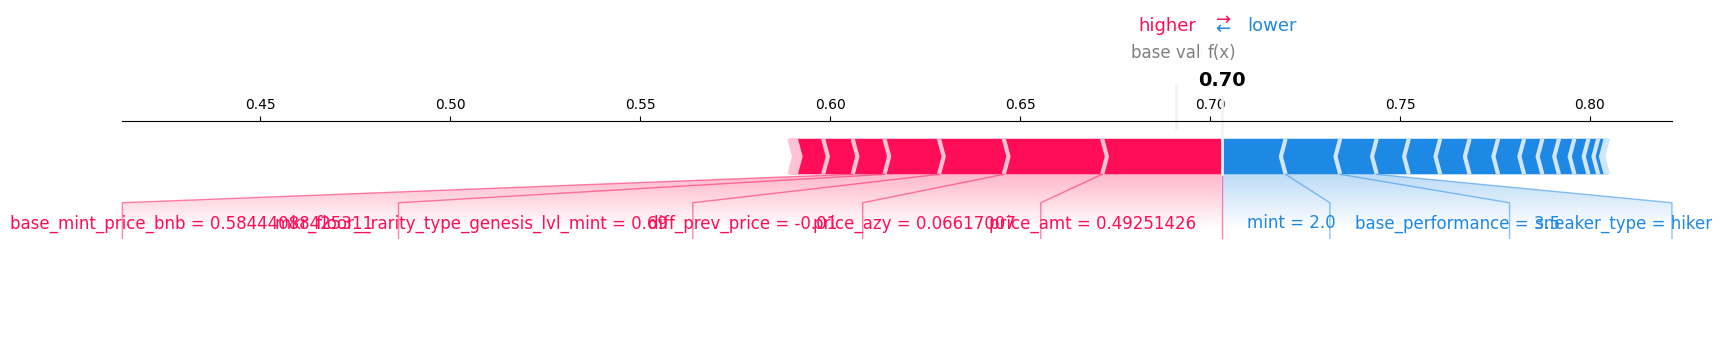

In [69]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [70]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [71]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [72]:
X.genesis.value_counts()

False    6691
True     3064
Name: genesis, dtype: int64

In [73]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,hiker,True,5.0,6.1,3.3,5.8,8.6,24.1,4.8,8.8,13.1,2.0
1,common,sprinter,False,5.0,8.1,7.7,1.2,8.9,27.1,11.7,1.7,13.4,2.0
2,common,ranger,False,0.0,9.2,4.6,3.3,7.2,9.2,4.6,3.3,7.2,0.0
3,common,sprinter,False,5.0,9.3,9.9,8.4,7.5,28.8,14.9,12.4,11.5,2.0
4,common,sprinter,True,5.0,8.2,3.4,5.8,6.9,27.2,4.9,8.8,10.4,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9750,common,coacher,False,5.0,2.3,6.3,6.7,7.4,18.3,9.3,10.2,10.9,0.0
9751,common,coacher,True,5.0,7.4,5.9,5.2,1.2,25.9,8.9,7.7,1.7,1.0
9752,common,coacher,True,5.0,4.8,4.6,3.3,3.6,22.3,7.1,4.8,5.6,1.0
9753,common,ranger,False,5.0,4.2,2.7,8.8,3.6,21.2,4.2,13.3,5.6,0.0


In [74]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.88s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.87s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:07,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:09,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:11,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:13,  1.87s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:14,  1.87s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:16,  1.87s/it]iteritems is deprec

In [75]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.830,0.1096
MAE,0.139,0.0138
MSE,0.119,0.1441
RMSE,0.307,0.1578
MAPE,0.163,0.0069


In [76]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.830,0.1096
MAE,0.139,0.0138
MSE,0.119,0.1441
RMSE,0.307,0.1578
MAPE,0.163,0.0069


In [77]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.81, 'MAE': 0.139, 'MSE': 0.119, 'RMSE': 0.344, 'MAPE': 0.163}

In [78]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


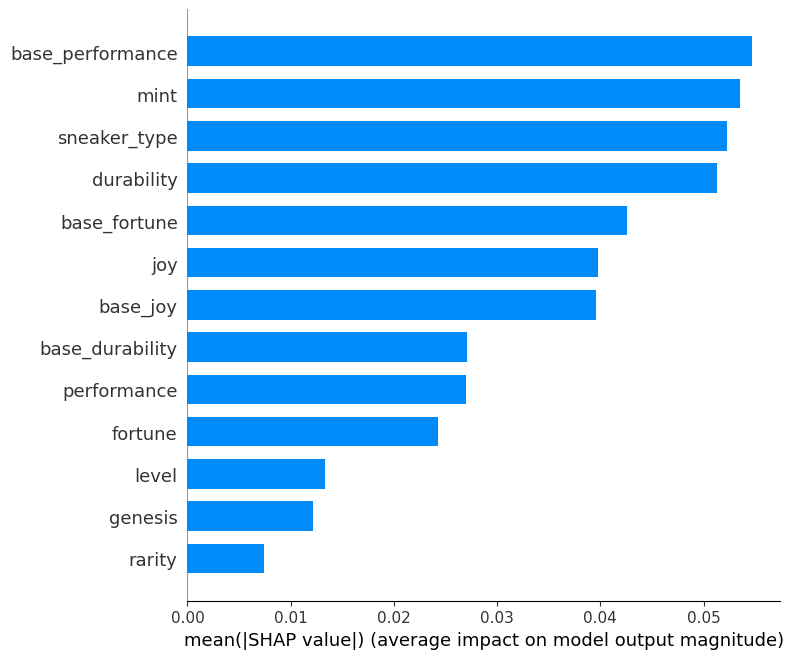

In [79]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [80]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [81]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.054936
0:	learn: 0.7614351	total: 2.27ms	remaining: 2.26s
1:	learn: 0.7356130	total: 4.97ms	remaining: 2.48s
2:	learn: 0.7095861	total: 7.89ms	remaining: 2.62s
3:	learn: 0.6845440	total: 10.1ms	remaining: 2.5s
4:	learn: 0.6608639	total: 11.8ms	remaining: 2.35s
5:	learn: 0.6387284	total: 13.6ms	remaining: 2.25s
6:	learn: 0.6170288	total: 15.5ms	remaining: 2.2s
7:	learn: 0.5968597	total: 17.4ms	remaining: 2.15s
8:	learn: 0.5786124	total: 19.2ms	remaining: 2.12s
9:	learn: 0.5605552	total: 21.2ms	remaining: 2.1s
10:	learn: 0.5442705	total: 23ms	remaining: 2.07s
11:	learn: 0.5287264	total: 24.8ms	remaining: 2.04s
12:	learn: 0.5133617	total: 26.6ms	remaining: 2.02s
13:	learn: 0.4989272	total: 28.5ms	remaining: 2.01s
14:	learn: 0.4853033	total: 30.5ms	remaining: 2s
15:	learn: 0.4732076	total: 32.3ms	remaining: 1.99s
16:	learn: 0.4626182	total: 34.2ms	remaining: 1.98s
17:	learn: 0.4512290	total: 36.1ms	remaining: 1.97s
18:	learn: 0.4400724	total: 38.1ms	remaining: 1.97s


{'R2': -0.954, 'MAE': 0.491, 'MSE': 0.44, 'RMSE': 0.663, 'MAPE': 1.402}

## Fit full Base model

In [82]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058678
0:	learn: 0.7025284	total: 3ms	remaining: 2.99s
1:	learn: 0.6779294	total: 5.99ms	remaining: 2.99s
2:	learn: 0.6552807	total: 8.58ms	remaining: 2.85s
3:	learn: 0.6345333	total: 11.1ms	remaining: 2.77s
4:	learn: 0.6148213	total: 13.8ms	remaining: 2.75s
5:	learn: 0.5974486	total: 16ms	remaining: 2.66s
6:	learn: 0.5805319	total: 18.4ms	remaining: 2.6s
7:	learn: 0.5644473	total: 20.7ms	remaining: 2.56s
8:	learn: 0.5497997	total: 22.7ms	remaining: 2.5s
9:	learn: 0.5355530	total: 26.4ms	remaining: 2.61s
10:	learn: 0.5222013	total: 29.2ms	remaining: 2.62s
11:	learn: 0.5101304	total: 31.6ms	remaining: 2.6s
12:	learn: 0.4986533	total: 34ms	remaining: 2.58s
13:	learn: 0.4881106	total: 36.2ms	remaining: 2.55s
14:	learn: 0.4785078	total: 38.5ms	remaining: 2.53s
15:	learn: 0.4690035	total: 40.7ms	remaining: 2.5s
16:	learn: 0.4606791	total: 43ms	remaining: 2.48s
17:	learn: 0.4523123	total: 45.3ms	remaining: 2.47s
18:	learn: 0.4452999	total: 47.5ms	remaining: 2.45s
19:	l

### Test

In [83]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [84]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

1.169

iteritems is deprecated and will be removed in a future version. Use .items instead.


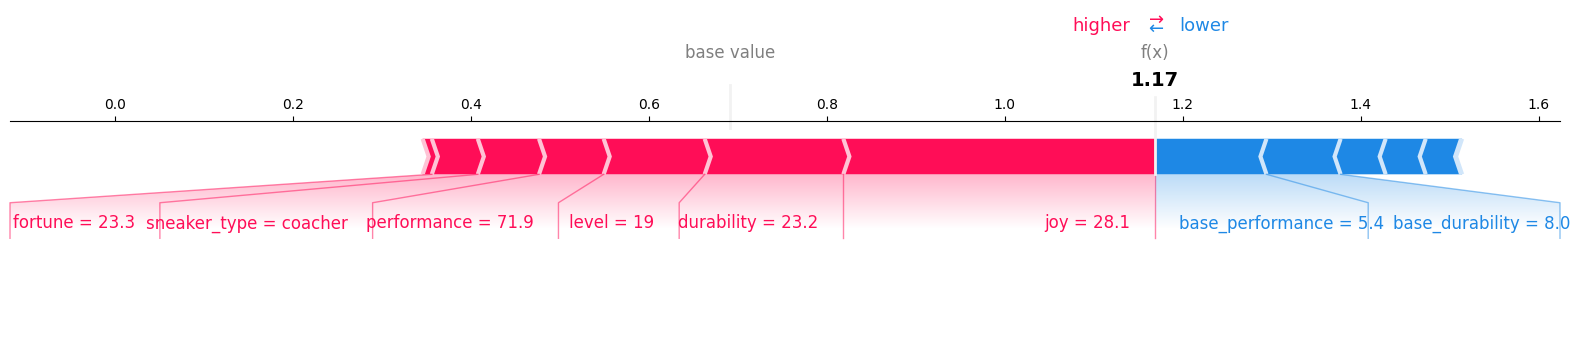

In [85]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

In [87]:
# sample = data[data['token_id'] == 20928][model.feature_names_][:1]
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(sample)
# shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
# #plt.savefig(f'explainer_{VERSION}.png', dpi=700)
# #plt.show()

In [88]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [89]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


In [90]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [91]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1665548320,64007,59227,buy,0x1e7b598b4e3c19d148743c5aa6cb88b1f43d9ae2,0x60d15e550ee1dca3c8a3a95081aa9e2f5d362716,0.40,box,common,NaN,...,0.36,0.36,0.22,43.0,44.0,44.0,100.0,866.0,110.0,976.0
1,1665548169,64502,67309,buy,0x43759b1c05a40dc5c1d08f027073231be904c05f,0x60d15e550ee1dca3c8a3a95081aa9e2f5d362716,0.32,box,common,NaN,...,0.32,0.32,0.22,44.0,45.0,45.0,101.0,866.0,111.0,977.0
2,1665537492,63668,68534,buy,0xe528a20c9c6ec8c9525437886f29e7515b9ba56c,0x414d66011635e1b351f36bd9a53305b840499e5c,0.40,box,common,NaN,...,0.32,0.32,0.22,45.0,46.0,46.0,102.0,866.0,112.0,978.0
3,1665537056,64451,64107,buy,0xc2c6fb3fbf16430519377074a890f6529e6d577b,0x414d66011635e1b351f36bd9a53305b840499e5c,0.36,box,common,NaN,...,0.32,0.32,0.22,46.0,47.0,47.0,103.0,862.0,113.0,975.0
4,1665537021,64305,68672,buy,0x2ddf5cdd3a014549b7dc6d6159b37638390d8a86,0x414d66011635e1b351f36bd9a53305b840499e5c,0.39,box,common,NaN,...,0.32,0.32,0.22,47.0,48.0,48.0,104.0,861.0,114.0,975.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1331,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1332,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [93]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [94]:
len(data)

1335

In [95]:
len(data[data.date >= START_DATE])

476

In [96]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [97]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659541e+09,1047.0,5.0,0.0,NaN,1800.0,300.0,200.0,0.660059
1,1.661162e+09,391549.0,0.0,0.0,NaN,1800.0,300.0,200.0,0.663558
2,1.661162e+09,390994.0,0.0,0.0,NaN,1800.0,300.0,200.0,0.663558
3,1.662405e+09,41067.0,1.0,0.0,NaN,1800.0,300.0,200.0,0.663558
4,1.661259e+09,1410.0,8.0,0.0,NaN,1800.0,300.0,200.0,0.662513
...,...,...,...,...,...,...,...,...,...
471,1.662376e+09,18952.0,1.0,0.0,NaN,1800.0,300.0,200.0,0.267188
472,1.657800e+09,16653.0,10.0,8.0,NaN,1800.0,300.0,200.0,0.267188
473,1.661259e+09,33003.0,10.0,0.0,NaN,1800.0,300.0,200.0,0.267433
474,1.657805e+09,26579.0,13.0,16.0,NaN,1800.0,300.0,200.0,0.271489


In [98]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1663652575,34241,53661,buy,False,sprinter,sprinter,2022-09-20 05:42:55
1,1663657353,31879,1671,buy,True,NaN,NaN,2022-09-20 07:02:33
2,1663657458,31127,8528,buy,True,NaN,NaN,2022-09-20 07:04:18
3,1663657464,34045,53396,buy,False,ranger,ranger,2022-09-20 07:04:24
4,1663658850,34275,53800,buy,False,ranger,sprinter,2022-09-20 07:27:30
...,...,...,...,...,...,...,...,...
471,1665537021,64305,68672,buy,False,hiker,coacher,2022-10-12 01:10:21
472,1665537056,64451,64107,buy,False,ranger,sprinter,2022-10-12 01:10:56
473,1665537492,63668,68534,buy,False,ranger,sprinter,2022-10-12 01:18:12
474,1665548169,64502,67309,buy,False,sprinter,sprinter,2022-10-12 04:16:09


In [99]:
data.genesis.value_counts()

False    453
True      23
Name: genesis, dtype: int64

In [100]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [101]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [102]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [103]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1663652575,34241,53661,buy,0x5a181a86735b86c6f2bc3784eb85d641af123254,0xf3bc39cc638be2b321132647aa72aaf965319f3e,0.99,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
1,1663657353,31879,1671,buy,0xa6ab391afaad74f1398641734d72018163d16220,0x078f1bdf9985b9bd1a6b35137418cbd3aca3631f,1.58,box,common,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1663657458,31127,8528,buy,0xa6ab391afaad74f1398641734d72018163d16220,0x078f1bdf9985b9bd1a6b35137418cbd3aca3631f,1.58,box,common,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1663657464,34045,53396,buy,0x1964175bd3b5259b0d6549bb826d697e8f32ca12,0x849709d587afc00652b11d830a8dbe3ffd25049a,1.11,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1663658850,34275,53800,buy,0xe528a20c9c6ec8c9525437886f29e7515b9ba56c,0xeda5c6db2a8265906030dbd3d4bfcf81707c8d52,1.09,box,common,NaN,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,1665537021,64305,68672,buy,0x2ddf5cdd3a014549b7dc6d6159b37638390d8a86,0x414d66011635e1b351f36bd9a53305b840499e5c,0.39,box,common,NaN,...,0,0,0,0,0,1,0,0,0,0
472,1665537056,64451,64107,buy,0xc2c6fb3fbf16430519377074a890f6529e6d577b,0x414d66011635e1b351f36bd9a53305b840499e5c,0.36,box,common,NaN,...,1,0,0,0,0,0,0,0,0,0
473,1665537492,63668,68534,buy,0xe528a20c9c6ec8c9525437886f29e7515b9ba56c,0x414d66011635e1b351f36bd9a53305b840499e5c,0.40,box,common,NaN,...,1,0,0,0,0,0,0,0,0,0
474,1665548169,64502,67309,buy,0x43759b1c05a40dc5c1d08f027073231be904c05f,0x60d15e550ee1dca3c8a3a95081aa9e2f5d362716,0.32,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0


In [104]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [105]:
data['ranger_hiker'].sum()

34

## FE

In [106]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [107]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [108]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [109]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.95it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.59it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  1.50it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.46it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:03,  1.44it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:04,  1.42it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:04,  1.42it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:05,  1.41it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:06,  1.41it/s]iteritems is deprec

In [110]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.533,3.3391
MAE,0.125,0.1312
MSE,0.846,1.5343
RMSE,0.567,0.7369
MAPE,0.067,0.0276


In [111]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.533,3.3391
MAE,0.125,0.1312
MSE,0.846,1.5343
RMSE,0.567,0.7369
MAPE,0.067,0.0276


In [112]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.007, 'MAE': 0.126, 'MSE': 0.852, 'RMSE': 0.923, 'MAPE': 0.067}

iteritems is deprecated and will be removed in a future version. Use .items instead.


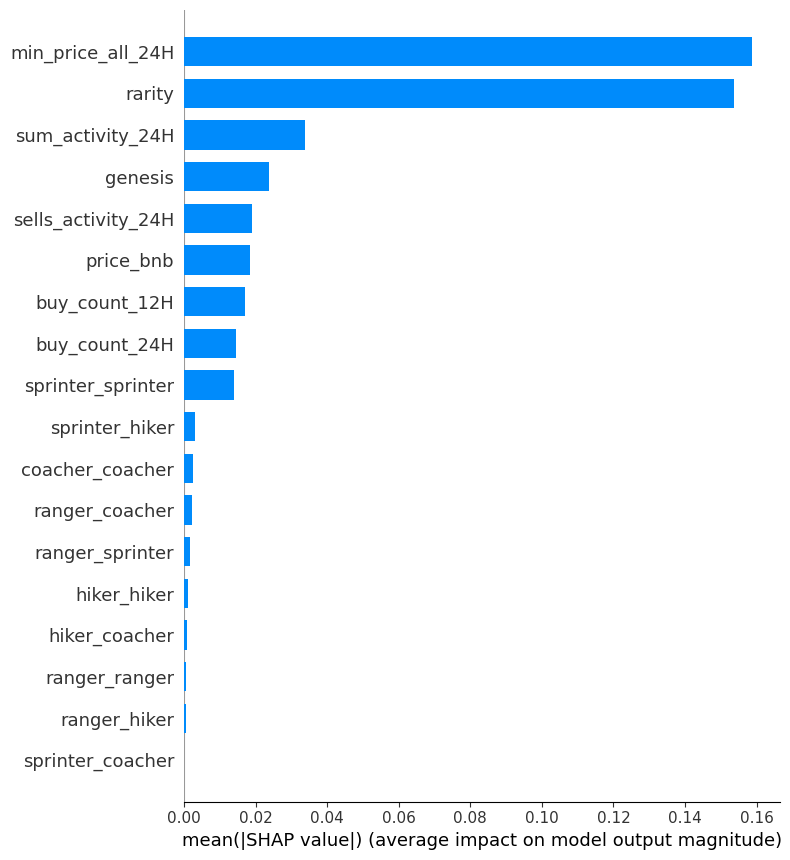

In [113]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [114]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.036412
0:	learn: 0.9126804	total: 1.06ms	remaining: 1.06s
1:	learn: 0.8987276	total: 1.9ms	remaining: 947ms
2:	learn: 0.8852106	total: 2.84ms	remaining: 945ms
3:	learn: 0.8722472	total: 3.48ms	remaining: 867ms
4:	learn: 0.8592178	total: 4.34ms	remaining: 864ms
5:	learn: 0.8464010	total: 5.19ms	remaining: 860ms
6:	learn: 0.8338152	total: 6.04ms	remaining: 857ms
7:	learn: 0.8216876	total: 6.82ms	remaining: 846ms
8:	learn: 0.8093827	total: 7.62ms	remaining: 839ms
9:	learn: 0.7973598	total: 8.3ms	remaining: 822ms
10:	learn: 0.7852422	total: 8.67ms	remaining: 779ms
11:	learn: 0.7741703	total: 9.24ms	remaining: 761ms
12:	learn: 0.7628170	total: 9.81ms	remaining: 745ms
13:	learn: 0.7516325	total: 10.5ms	remaining: 737ms
14:	learn: 0.7405403	total: 11.1ms	remaining: 730ms
15:	learn: 0.7300621	total: 11.8ms	remaining: 727ms
16:	learn: 0.7194181	total: 12.6ms	remaining: 728ms
17:	learn: 0.7088256	total: 13.2ms	remaining: 720ms
18:	learn: 0.6985754	total: 13.9ms	remaining: 

### Test

In [115]:
i = 250

In [116]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1664655691,
 'mrk_id': 47301,
 'token_id': 62957,
 'event': 'buy',
 'wallet_from': '0x902379d54875e867a840268b5eb08721b70ed0e0',
 'wallet_to': '0x2b6c6519b654d0451548f5787b217412ed273a12',
 'price': 0.69,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 34521.0,
 'parent2': 34957.0,
 'genesis': False,
 'parent1_sneaker_type': 'sprinter',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 281.47544343,
 'price_azy': 0.06408579,
 'price_amt': 0.34551601,
 'wallet_from_buy_count': 0.0,
 'wallet_from_all_count': 1.0,
 'token_all_activity_3H': 0.0,
 'token_sell_activity_6H': 0.0,
 'buy_count_12H': 16.0,
 'buy_count_24H': 20,
 'buy_count_48H': 45.0,
 'sell_count_12H': 28.0,
 'sell_count_24H': 49,
 'sell_count_48H': 106.0,
 'cancel_count_12H': 19.0,
 'cancel_count_

In [117]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H              16.0
buy_count_24H                20
sum_activity_24H             98
sells_activity_24H         2.45
min_price_all_24H          0.62
price_bnb                   NaN
ranger_sprinter             NaN
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter             1
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count       0.0
wallet_from_all_count       1.0
dtype: object

In [118]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

0.695

In [119]:
data.iloc[i]['price']

0.69

In [120]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.081

In [121]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.966

# Box Base Model

In [122]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [123]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [124]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [125]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             476 non-null    object
 1   genesis            476 non-null    bool  
 2   ranger_sprinter    476 non-null    int64 
 3   ranger_hiker       476 non-null    int64 
 4   ranger_coacher     476 non-null    int64 
 5   sprinter_hiker     476 non-null    int64 
 6   sprinter_coacher   476 non-null    int64 
 7   hiker_coacher      476 non-null    int64 
 8   ranger_ranger      476 non-null    int64 
 9   sprinter_sprinter  476 non-null    int64 
 10  hiker_hiker        476 non-null    int64 
 11  coacher_coacher    476 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 41.5+ KB


In [126]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  4.64it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.80it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.48it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.40it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  2.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.25it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  2.23it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:03,  2.22it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:03,  2.20it/s]iteritems is deprec

In [127]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.171,0.5857
MAE,0.234,0.1321
MSE,0.681,1.5729
RMSE,0.527,0.6454
MAPE,0.256,0.0482


In [128]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.171,0.5857
MAE,0.234,0.1321
MSE,0.681,1.5729
RMSE,0.527,0.6454
MAPE,0.256,0.0482


In [129]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.2, 'MAE': 0.235, 'MSE': 0.686, 'RMSE': 0.828, 'MAPE': 0.256}

iteritems is deprecated and will be removed in a future version. Use .items instead.


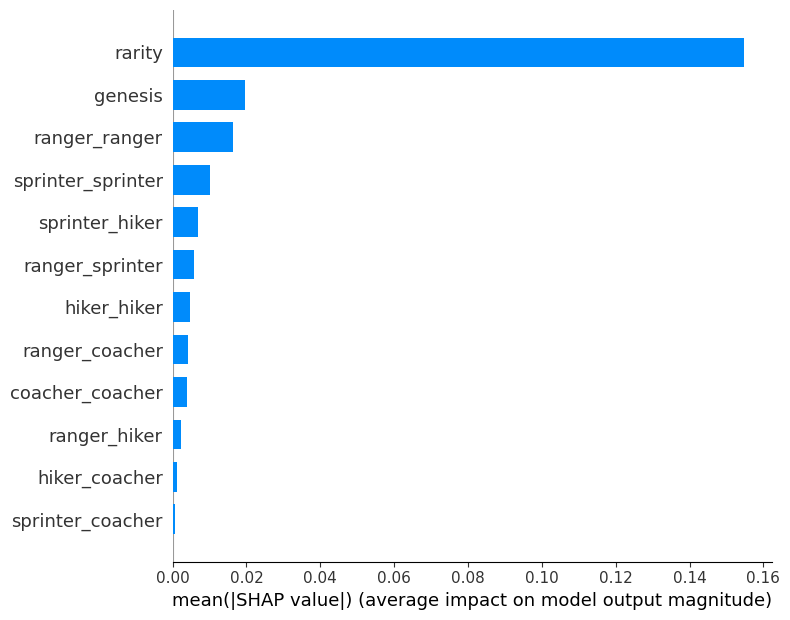

In [130]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [131]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.036412
0:	learn: 0.9142388	total: 514us	remaining: 514ms
1:	learn: 0.9027209	total: 849us	remaining: 424ms
2:	learn: 0.8939143	total: 1.74ms	remaining: 580ms
3:	learn: 0.8813412	total: 2.13ms	remaining: 530ms
4:	learn: 0.8692510	total: 2.55ms	remaining: 507ms
5:	learn: 0.8573888	total: 2.89ms	remaining: 478ms
6:	learn: 0.8460296	total: 3.47ms	remaining: 493ms
7:	learn: 0.8350895	total: 4.07ms	remaining: 505ms
8:	learn: 0.8273238	total: 4.82ms	remaining: 531ms
9:	learn: 0.8197381	total: 5.33ms	remaining: 528ms
10:	learn: 0.8108338	total: 5.6ms	remaining: 504ms
11:	learn: 0.8033487	total: 6.05ms	remaining: 498ms
12:	learn: 0.7935171	total: 6.47ms	remaining: 492ms
13:	learn: 0.7838945	total: 6.89ms	remaining: 485ms
14:	learn: 0.7777839	total: 7.47ms	remaining: 491ms
15:	learn: 0.7688256	total: 8.23ms	remaining: 506ms
16:	learn: 0.7599544	total: 8.55ms	remaining: 494ms
17:	learn: 0.7509499	total: 8.9ms	remaining: 486ms
18:	learn: 0.7425135	total: 9.25ms	remaining: 47

## Test

In [132]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.888

In [133]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [134]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [135]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [136]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

0.69

In [137]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.613

In [138]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.613

In [139]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.978

In [140]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.804

In [141]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.784

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [ ]:
# import ast
# import json

In [ ]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [ ]:
# print(json.dumps(json_data))

In [ ]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [ ]:
#output = json.loads(r.text)

In [ ]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

In [ ]:
{'token_id': 42349, 'item_type': 'sneakers', 'rarity': 'common', 'sneaker_type': 'sprinter', 'genesis': False, 'level': 8, 'base_performance': 2.7, 
'base_fortune': 6.3, 'base_joy': 9.4, 'base_durability': 4.9, 'performance': 25.1, 'fortune': 11.1, 'joy': 18.6, 'durability': 10.9, 'mint': 2, 
'parent1_sneaker_type': 'sprinter', 'parent2_sneaker_type': 'coacher', 'wallet_from_buy_count': None, 'wallet_from_all_count': None, 
'buy_count_12H': None, 
'buy_count_24H': 1398, 'buy_count_48H': None, 'sell_count_12H': None, 
'sell_count_24H': 3221, 
'sell_count_48H': None, 'cancel_count_12H': None, 
'cancel_count_24H': 1706, 'cancel_count_48H': None, 'min_price_all_24H': 0.5, 'min_price_by_rarity_genesis_type_level_mint_24H': None, 'min_price_by_rarity_genesis_type_level_mint_48H': 0.52, 'min_price_by_rarity_genesis_type_level_mint_72H': None, 'min_price_by_rarity_genesis_type_24H': 0.5, 'min_price_by_rarity_genesis_type_48H': None, 'min_price_by_rarity_genesis_type_72H': None, 'token_all_activity_3H': None, 'token_sell_activity_6H': None, 'price_bnb': 273.3326244499208, 'price_azy': 0.05407691570187973, 'price_amt': 0.24430650686382938, 'wallet_first_sneaker_time': None, 'time_ownership': None, 'wallet_box_mint': None, 'wallet_sneaker_mint': None, 'time_level_up': 2160, 'time_level_up_for_mint': 1800, 'base_mint_price_amt': 300.0, 'base_mint_price_azy': 200.0, 
'base_mint_price_bnb': 0.3077105609650145, 
'price': 0.31, 'explain_models': False}

{'token_id': 42349,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'sprinter',
 'genesis': False,
 'level': 8,
 'base_performance': 2.7,
 'base_fortune': 6.3,
 'base_joy': 9.4,
 'base_durability': 4.9,
 'performance': 25.1,
 'fortune': 11.1,
 'joy': 18.6,
 'durability': 10.9,
 'mint': 2,
 'parent1_sneaker_type': 'sprinter',
 'parent2_sneaker_type': 'coacher',
 'wallet_from_buy_count': None,
 'wallet_from_all_count': None,
 'buy_count_12H': None,
 'buy_count_24H': 1398,
 'buy_count_48H': None,
 'sell_count_12H': None,
 'sell_count_24H': 3221,
 'sell_count_48H': None,
 'cancel_count_12H': None,
 'cancel_count_24H': 1706,
 'cancel_count_48H': None,
 'min_price_all_24H': 0.5,
 'min_price_by_rarity_genesis_type_level_mint_24H': None,
 'min_price_by_rarity_genesis_type_level_mint_48H': 0.52,
 'min_price_by_rarity_genesis_type_level_mint_72H': None,
 'min_price_by_rarity_genesis_type_24H': 0.5,
 'min_price_by_rarity_genesis_type_48H': None,
 'min_price_by_rarity_genesis_type_

групировку делать по sell оредерам